In [1]:
#! pip install scikit-learn
#! pip install pandas
import os
from os.path import join
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from layers_train import ConvOffset2D_train
import matplotlib.pyplot as plt
%matplotlib inline

datapath = join('data', 'wafer')

#print(os.listdir("data/input"))
import warnings
warnings.filterwarnings("ignore")

2023-11-23 14:19:45.079034: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
df=pd.read_pickle("./LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df = df.drop(['waferIndex'], axis = 1)

In [4]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(2)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
491365,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot30382,[],[],"(32, 29)"
482627,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot29900,[],[],"(32, 29)"


In [5]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

# for i in range(len(sub_df[:15000])):
for i in range(len(sub_df[:30000])):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [6]:
# from keras import layers
# from keras.layers import Input
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [7]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14312, 26, 26), y shape : (14312, 1)


In [8]:
#! pip install pip opencv-python

In [9]:
import cv2
a = list([1]*14312)  # 14366
print(len(a))
for i in range(14312):
#     a[i] = cv2.copyMakeBorder(x[i],35,35,35,35,cv2.BORDER_CONSTANT,value=[0,255,0])
    a[i] = cv2.resize(x[i], (26, 26), interpolation=cv2.INTER_CUBIC)

14312


In [10]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [11]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 71
none : 13436


In [12]:
#add channel
a_list = list()
for i in range(14312):
    a_list.append(a[i].reshape(26, 26, 1))

In [13]:
a_array = np.array(a_list)
a_array.shape

(14312, 26, 26, 1)

In [14]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(a_array), 26, 26, 3))

for w in range(len(a_array)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(a_array[w, i, j])] = 1

In [15]:
new_x.shape

(14312, 26, 26, 3)

In [16]:
from tensorflow.keras.layers import Input
from tensorflow.keras import layers,models

In [17]:
# parameter
epoch=15
batch_size=16


In [18]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(128, (3,3), padding='same', activation='relu')(input_tensor)
encode = ConvOffset2D_train(128)(encode)
latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(128, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
 )

In [19]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 128)       3584      
_________________________________________________________________
conv_offset2d_train (ConvOff (None, 26, 26, 128)       294912    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13, 13, 128)       147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 3)         3459  

In [20]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Train on 14312 samples
Epoch 1/15


2023-11-23 14:26:32.652456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-23 14:26:32.679828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA RTX A4000 major: 8 minor: 6 memoryClockRate(GHz): 1.56
pciBusID: 0000:d1:00.0
2023-11-23 14:26:32.679869: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-11-23 14:26:32.685803: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-11-23 14:26:32.688623: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2023-11-23 14:26:32.688953: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2023-11-23 14:26:32.689586: I tensorflow/stream_executor/platform/default

14312/14312 - 103s - loss: 0.0168
Epoch 2/15
14312/14312 - 90s - loss: 0.0021
Epoch 3/15
14312/14312 - 90s - loss: 0.0010
Epoch 4/15
14312/14312 - 90s - loss: 6.3701e-04
Epoch 5/15
14312/14312 - 90s - loss: 4.3565e-04
Epoch 6/15
14312/14312 - 90s - loss: 3.1698e-04
Epoch 7/15
14312/14312 - 91s - loss: 2.4077e-04
Epoch 8/15
14312/14312 - 90s - loss: 2.0054e-04
Epoch 9/15
14312/14312 - 89s - loss: 1.6496e-04
Epoch 10/15
14312/14312 - 89s - loss: 1.3613e-04
Epoch 11/15
14312/14312 - 89s - loss: 1.2115e-04
Epoch 12/15
14312/14312 - 90s - loss: 9.7525e-05
Epoch 13/15
14312/14312 - 90s - loss: 8.5400e-05
Epoch 14/15
14312/14312 - 90s - loss: 7.4405e-05
Epoch 15/15
14312/14312 - 90s - loss: 7.4919e-05


In [21]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [22]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 128))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [23]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [24]:
noised_encoded_x = encoded_x + np.random.normal(loc=0.01, scale=0.1, size = (len(encoded_x), 13, 13, 128))

In [25]:
# check original faulty wafer data
noised_gen_x = np.argmax(noised_encoded_x,axis=3)
#plt.imshow(noised_gen_x[3])
#plt.show()
#print('Faulty case : {} '.format(y[3]))

In [26]:
np.where(y=='Donut')

(array([10686]), array([0]))

In [27]:
y.shape

(14312, 1)

In [187]:
noised_encoded_x.shape

(4428, 13, 13, 128)

In [28]:
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x),axis=3)

In [ ]:
gen_x = np.argmax(decoder.predict(encoded_x), axis=3)
#plt.imshow(gen_x[3])

In [42]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((100//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0.8, scale=0.7, size = (len(encoded_x), 13, 13, 128)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [43]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [44]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (5212, 26, 26, 3), new_y shape : (5212, 1)


In [45]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 112
Edge-Loc : 183
Edge-Ring : 110
Loc : 155
Near-full : 108
Random : 133
Scratch : 126
none : 4285


In [46]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=4285, replace=False)]

In [47]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [48]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (927, 26, 26, 3), new_y shape : (927, 1)


In [49]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 112
Edge-Loc : 183
Edge-Ring : 110
Loc : 155
Near-full : 108
Random : 133
Scratch : 126
none : 0


In [44]:
from matplotlib import rcParams

In [50]:
np.where(new_y=='Center')

(array([ 10,  14,  20,  58, 102, 122, 137, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
        188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
        201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
        214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
        227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
        240, 241, 242, 243, 244, 245, 246, 247]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

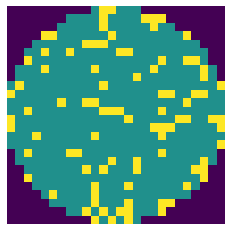

In [36]:
import matplotlib.pyplot as plt
#plt.rcParams["font.family"] = "Times New Roman"

plt.axis('off')
plt.imshow(np.argmax(new_x[3],axis = 2))
plt.savefig('gen_x.png', dpi=300)
#plt.show()
#print('Faulty case : {} '.format(new_y[3]))